In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
%matplotlib inline

In [2]:
# Camera Calibration

objpoints = []
imgpoints = []

images = glob.glob('camera_cal/calibration*.jpg')

for fname in images:
    
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

    else:
        im_num = int(fname.split('.')[0][-1])
        if im_num == 5:
            ret, corners = cv2.findChessboardCorners(gray, (7,5), None)
            objp = np.zeros((5*7,3), np.float32)
            objp[:,:2] = np.mgrid[0:5,0:7].T.reshape(-1,2)
        elif im_num == 4:
            ret, corners = cv2.findChessboardCorners(gray, (6,5), None)
            objp = np.zeros((5*6,3), np.float32)
            objp[:,:2] = np.mgrid[0:6,0:5].T.reshape(-1,2)
        elif im_num == 1:
            ret, corners = cv2.findChessboardCorners(gray, (9,5), None)
            objp = np.zeros((5*9,3), np.float32)
            objp[:,:2] = np.mgrid[0:9,0:5].T.reshape(-1,2)
        assert ret
        objpoints.append(objp)
        imgpoints.append(corners)

In [3]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.T.shape, None, None, flags = cv2.CALIB_USE_INTRINSIC_GUESS)

In [4]:
# Perspective Transform

def perspective_transform(img):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    trap_pts = np.array([[197,720], [580, 460], [702, 460], [1115, 720]], np.int32)
    trap = np.copy(gray)
    trap = cv2.polylines(trap, [trap_pts], True, (0, 255, 0), thickness = 2)
    src_pts = np.float32(trap_pts)
    dest_pts = np.array([[350, 720], [350, 0], [970, 0], [970, 720]], np.float32)
    M = cv2.getPerspectiveTransform(src_pts, dest_pts)
    Minv = cv2.getPerspectiveTransform(dest_pts, src_pts)
    warped = cv2.warpPerspective(trap, M, (1280, 720), flags = cv2.INTER_LINEAR)
    
    return M, Minv, warped

base = (plt.imread('test_images/straight_lines1.jpg'))
M, Minv, birds_eye = perspective_transform(base)

In [5]:
# Saturation thresholding

def sat_thresh(img, thresh = (0, 255)):

    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    sat = hls[:,:,2]
    binary_output = np.zeros_like(sat)

    binary_output[(sat > thresh[0]) & (sat < thresh[1])] = 1
    
    return binary_output

# Hue thresholding

def hue_thresh(img, thresh = (0, 255)):

    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hue = hls[:,:,0]
    binary_output = np.zeros_like(hue)

    binary_output[(hue > thresh[0]) & (hue < thresh[1])] = 1
    
    return binary_output

# Derivative thresholding

def abs_sobel_thresh(img, orient='x', ksize = 3, thresh = (0, 255)):
    
    assert ksize % 2 == 1
#   Using gray images to identify white lines better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     sat = hls[:,:,2]
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = ksize)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = ksize)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1
    return binary_output

def mag_thresh(img, ksize = 3, thresh = (0, 255)):
    
    assert ksize % 2 == 1
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    sat = hls[:,:,2]
    sobelx = cv2.Sobel(sat, cv2.CV_64F, 1, 0, ksize = ksize)
    sobely = cv2.Sobel(sat, cv2.CV_64F, 0, 1, ksize = ksize)
#   scaling magnitude of y because it introduces noise
    abs_sobelxy = np.sqrt(sobelx**2 + 0.3 * sobely**2)
    scaled = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    binary_output = np.zeros_like(scaled)
    binary_output[(scaled > thresh[0]) & (scaled < thresh[1])] = 1
    
    return binary_output

def dir_thresh(img, ksize = 3, thresh = (0, np.pi/2)):

    assert ksize % 2 == 1
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     sat = hls[:,:,2]
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = ksize)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = ksize)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    grad = np.arctan2(abs_sobely, abs_sobelx)
    binary_output = np.zeros_like(gray)
    binary_output[(grad > thresh[0]) & (grad < thresh[1])] = 1
#   cv2 morphological transform
    kernel = np.ones((5,5), np.uint8)
    binary_output = cv2.morphologyEx(binary_output, cv2.MORPH_OPEN, kernel)
    
    return binary_output

In [6]:
def reinforce(img, kernel = (3,3)):
    blur = cv2.GaussianBlur(img, (7,7), 0)
    kernel = np.ones(kernel, np.uint8)
    dilation = cv2.dilate(blur, kernel, iterations = 1)
    return dilation

In [7]:
def roi(img, vertices):
    
    mask = np.zeros_like(img)
    
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_img = cv2.bitwise_and(img, mask)
    
    return masked_img

In [8]:
def util(result):
    
    ploty = np.linspace(0, 719, num=720)
    quadratic_coeff = 3e-4
    leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                      for y in ploty])
    rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                        for y in ploty])
    leftx = leftx[::-1]
    rightx = rightx[::-1]
    left_fit_new = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit_new[0]*ploty**2 + left_fit_new[1]*ploty + left_fit_new[2]
    right_fit_new = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit_new[0]*ploty**2 + right_fit_new[1]*ploty + right_fit_new[2]
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit_new[0]*y_eval + left_fit_new[1])**2)**1.5) / np.absolute(2*left_fit_new[0])
    right_curverad = ((1 + (2*right_fit_new[0]*y_eval + right_fit_new[1])**2)**1.5) / np.absolute(2*right_fit_new[0])
        
    ym_per_pix = 30/720 
    xm_per_pix = 3.7/700

    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    middle = (left_fitx[-1] + right_fitx[-1])//2
    position = img.shape[1]//2
    l_or_r = (position - middle)*xm_per_pix
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,'Left radius of curvature  = %.2f m'%(left_curverad),(150,50), font, 1,(255,0,0),3,cv2.LINE_AA)
    cv2.putText(result,'Right radius of curvature = %.2f m'%(right_curverad),(150,90), font, 1,(255,0,0),3,cv2.LINE_AA)
    cv2.putText(result,'Position = %.2f m %s of center'%(abs(l_or_r), 'left' if l_or_r < 0 else 'right'),(150,130),
                        font, 1,(255,255,255),3,cv2.LINE_AA)
    return result


In [9]:
left_fit = []
right_fit = []
found = 0

In [12]:
def pipeline(img, mtx, dist, M, Minv, found):
    
    img = cv2.undistort(img, mtx, dist, None, mtx)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
#   Coordinates for ROI
    height, width = gray.shape
    offset = (width - height)/5
    bottom_left = (width/10, height)
    top_left = (width/2 - offset, height/1.8)
    top_right = (width/2 + offset, height/1.8)
    bottom_right = (width - width/10, height)
    vertices = np.array([[top_left, bottom_left, bottom_right, top_right]], np.int32)
    poly_pts = vertices.reshape((-1, 1, 2))
    
#   Collecting all the filter images
    gradx = abs_sobel_thresh(img, orient = 'x', ksize = 9, thresh = (20, 100))
    grady = abs_sobel_thresh(img, orient = 'y', ksize = 9, thresh = (20, 100))
    mag_binary = mag_thresh(img, ksize = 9, thresh = (30, 100))
    dir_binary = dir_thresh(img, ksize = 13, thresh = (0.8, 1.2))
    sat_binary = sat_thresh(img, thresh = (130, 255))
    hue_binary = hue_thresh(img, thresh = (10, 60))
    
#   Applying all the filters
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | (((dir_binary == 1) | (mag_binary == 1)) & ((sat_binary == 1) | (mag_binary == 1)))] = 1
    
    dilated = reinforce(combined)
    
#   Segregating ROI
    masked = roi(dilated, vertices)
    
#   Warping
    warped_curve = cv2.warpPerspective(masked, M, (1280, 720), flags = cv2.INTER_LINEAR)
    binary_warped = np.copy(warped_curve)
#     half = binary_warped[binary_warped.shape[0]//2:,:]
    
    if not found:
        
        histogram = np.sum(binary_warped, axis = 0)
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        nwindows = 9
        window_height = np.int(binary_warped.shape[0]/nwindows)
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        leftx_current = leftx_base
        rightx_current = rightx_base
        margin = 100
        minpix = 50
        left_lane_inds = []
        right_lane_inds = []

        for window in range(nwindows):
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (0,255,0), 2) 
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        found = 1
        
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))
        result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
        final = util(result)

    else:
        
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
        left_fit[1]*nonzeroy + left_fit[2] + margin))) 

        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
        right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
        result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
        final = util(result)
    return final

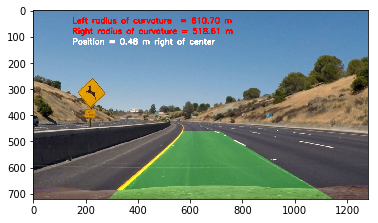

In [13]:
test = plt.imread('test_images/test2.jpg')
check = pipeline(test, mtx, dist, M, Minv, found)
plt.imshow(check)

In [17]:
def process_image(image):
    result = pipeline(image, mtx, dist, M, Minv, found)    
    return result

In [18]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [19]:
white_output = 'run_radii.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video run_radii.mp4
[MoviePy] Writing video run_radii.mp4


100%|█████████▉| 1260/1261 [09:22<00:00,  1.96it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: run_radii.mp4 

CPU times: user 12min 11s, sys: 12.1 s, total: 12min 23s
Wall time: 9min 25s
